Movie Watching Habits - CS 210 Project

Import

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
import seaborn as sns 
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re

Data Collection

In [21]:
def extract_filtered_lines(url):
    response = requests.get(url)
 
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        lines_list = []

        links = soup.find_all('a')

        for link in links:
            href = link.get('href')
            lines_list.append(href)

        filtered_lines = [line for line in lines_list
                          if line.startswith('/slimsdan/films/diary/for/')
                          or line.startswith('/slimsdan/film/')]

        return filtered_lines

    else:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")
        return None

urls = [
    'https://letterboxd.com/slimsdan/films/diary/page/1/',
    'https://letterboxd.com/slimsdan/films/diary/page/2/',
    'https://letterboxd.com/slimsdan/films/diary/page/3/',
    'https://letterboxd.com/slimsdan/films/diary/page/4/',
    'https://letterboxd.com/slimsdan/films/diary/page/5/'
]

all_filtered_lines = []
for url in urls:
    filtered_lines = extract_filtered_lines(url)
    if filtered_lines:
        all_filtered_lines.extend(filtered_lines)

if len(all_filtered_lines) >= 20:
    all_filtered_lines = all_filtered_lines[:-20]
else:
    print("Not enough lines to remove 20 lines.")

Dataframe of Movie Names and Dates 

In [22]:
movie_data = []
current_date = None

for line in all_filtered_lines:
    if line.startswith('/slimsdan/films/diary/for/'):
        match = re.search(r'\d{4}/\d{2}/\d{2}', line)
        if match:
            current_date = match.group()
    elif line.startswith('/slimsdan/film/'):
        parts = line.split('/')
        movie_name = next((p for p in parts[3:] if p and not p.isdigit()), None)
        if movie_name:
            movie_name = movie_name.replace('-', ' ')
            movie_data.append((movie_name, current_date))


df = pd.DataFrame(movie_data, columns=['Movie', 'Watch Date'])

df.head()

,Movie,Watch Date
0,the holdovers,2023/12/03
1,anatomy of a fall,2023/10/21
2,killers of the flower moon,2023/10/20
3,the blair witch project,2023/10/19
4,midnight cowboy,2023/10/14


Movies per Day for Specific Date Ranges

In [23]:
df['Watch Date'] = pd.to_datetime(df['Watch Date'])
date_ranges = [
    ('2021-10-02', '2021-12-26'),
    ('2021-12-27', '2022-01-04'),
    ('2022-01-05', '2022-01-21'),
    ('2022-01-22', '2022-02-06'),
    ('2022-02-07', '2022-02-27'),
    ('2022-02-28', '2022-06-10'),
    ('2022-06-11', '2022-06-23'),
    ('2022-06-24', '2022-07-22'),
    ('2022-07-23', '2022-08-10'),
    ('2022-08-11', '2022-09-08'),
    ('2022-09-09', '2022-10-02'),
    ('2022-10-03', '2023-01-06'),
    ('2023-01-07', '2023-01-14'),
    ('2023-01-15', '2023-01-26'),
    ('2023-01-27', '2023-02-26'),
    ('2023-02-26', '2023-05-31'),
    ('2023-06-01', '2023-06-11'),
    ('2023-06-12', '2023-06-21'),
    ('2023-06-22', '2023-07-30'),
    ('2023-07-31', '2023-08-14'),
    ('2023-08-15', '2023-08-30'),
    ('2023-08-31', '2023-10-01'),
    ('2023-10-02', '2023-12-22')
]
results = []
for start_date, end_date in date_ranges:
    filtered_data = df.loc[(df['Watch Date'] >= start_date) & (df['Watch Date'] <= end_date)]
    total_movies_watched = len(filtered_data)
    
    num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    movies_per_day = total_movies_watched / num_days if num_days != 0 else 0

    results.append({
        'Date Range': f'{start_date} to {end_date}',
        'Total Movies Watched': total_movies_watched,
        'Movies Watched per Day': movies_per_day
    })

results_df = pd.DataFrame(results)
print(results_df)
results_df.head()

                  Date Range  Total Movies Watched  Movies Watched per Day
0   2021-10-02 to 2021-12-26                    46                0.534884
1   2021-12-27 to 2022-01-04                     0                0.000000
2   2022-01-05 to 2022-01-21                    18                1.058824
3   2022-01-22 to 2022-02-06                    13                0.812500
4   2022-02-07 to 2022-02-27                     6                0.285714
5   2022-02-28 to 2022-06-10                     4                0.038835
6   2022-06-11 to 2022-06-23                     1                0.076923
7   2022-06-24 to 2022-07-22                     3                0.103448
8   2022-07-23 to 2022-08-10                     9                0.473684
9   2022-08-11 to 2022-09-08                     2                0.068966
10  2022-09-09 to 2022-10-02                    20                0.833333
11  2022-10-03 to 2023-01-06                     7                0.072917
12  2023-01-07 to 2023-01

,Date Range,Total Movies Watched,Movies Watched per Day
0,2021-10-02 to 2021-12-26,46,0.534884
1,2021-12-27 to 2022-01-04,0,0.000000
2,2022-01-05 to 2022-01-21,18,1.058824
3,2022-01-22 to 2022-02-06,13,0.812500
4,2022-02-07 to 2022-02-27,6,0.285714


Scraping and Adding Movie Lengths

In [24]:
base_url = 'https://letterboxd.com/film/'
def format_movie_url(movie_name):
    formatted_name = movie_name.lower().replace(' ', '-')
    return base_url + formatted_name + '/'
movies_and_urls = [(movie, format_movie_url(movie)) for movie in df['Movie']]

In [25]:
def scrape_movie_length(movie_url):
    response = requests.get(movie_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        length_element = soup.find('p', class_='text-link text-footer')
        if length_element:
            length_text = length_element.get_text(strip=True)
            length = ''.join(filter(str.isdigit, length_text))
            return int(length) if length else None
    return None
movie_lengths = []
number = 1

for movie, url in movies_and_urls:
    length = scrape_movie_length(url)
   
    movie_lengths.append((movie, length))

df_movie_lengths = pd.DataFrame(movie_lengths, columns=['Movie', 'Length_Minutes'])
df_movie_lengths.head()

,Movie,Length_Minutes
0,the holdovers,133
1,anatomy of a fall,152
2,killers of the flower moon,206
3,the blair witch project,81
4,midnight cowboy,113


Merging Date and Length of Movies

In [26]:
merged_df = pd.merge(df, df_movie_lengths, on='Movie', how='inner')
movie_counts = merged_df.groupby('Movie').size()
merged_df.head()

,Movie,Watch Date,Length_Minutes
0,the holdovers,2023-12-03,133
1,anatomy of a fall,2023-10-21,152
2,killers of the flower moon,2023-10-20,206
3,the blair witch project,2023-10-19,81
4,midnight cowboy,2023-10-14,113


Bar Charts

Total Number of Movies Watched per 10-Day Periods

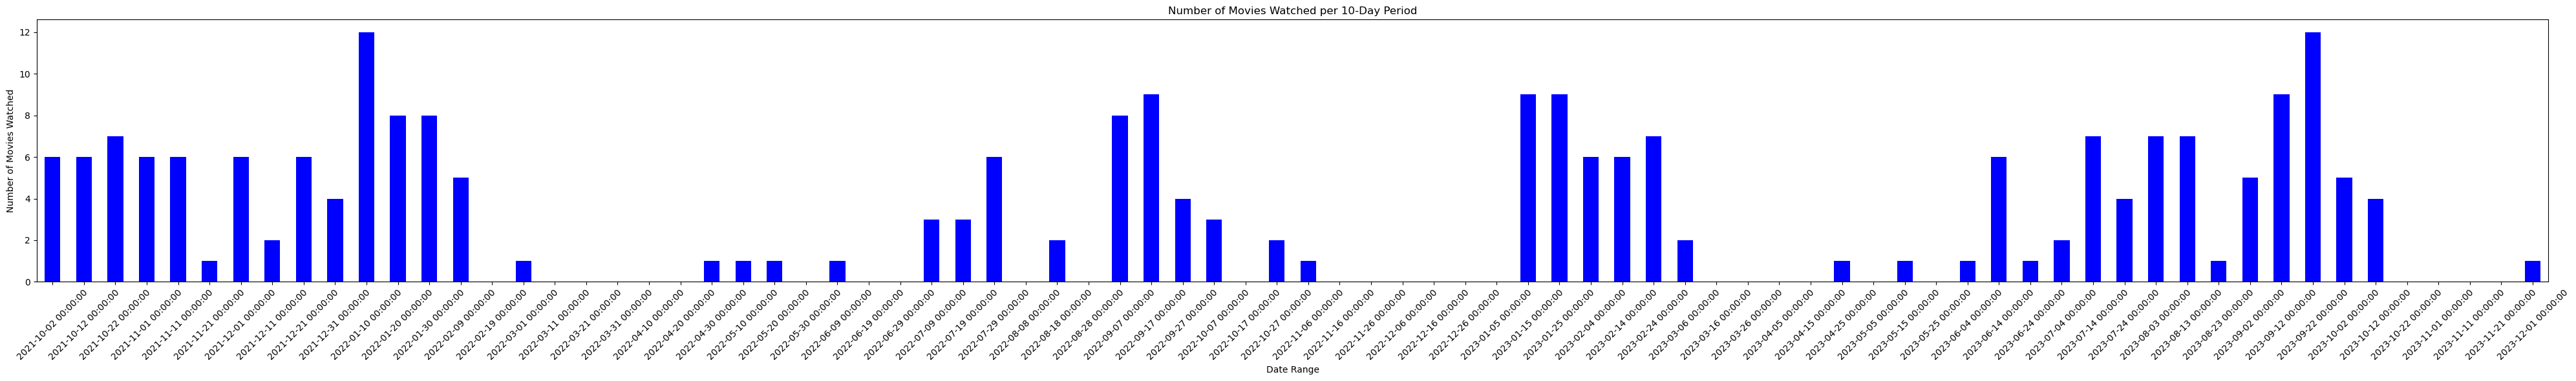

In [27]:
df['Watch Date'] = pd.to_datetime(df['Watch Date'])

start_date = '2021-10-02'
end_date = '2023-12-22'
filtered_data = df.loc[(df['Watch Date'] >= start_date) & (df['Watch Date'] <= end_date)]

movies_per_day = filtered_data.groupby('Watch Date').size()

movies_per_week = movies_per_day.resample('10D').sum()

plt.figure(figsize=(40, 6))
movies_per_week.plot(kind='bar', color='blue')
plt.title('Number of Movies Watched per 10-Day Period')
plt.xlabel('Date Range')
plt.ylabel('Number of Movies Watched')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Total Minutes Watched for 10-Day Periods

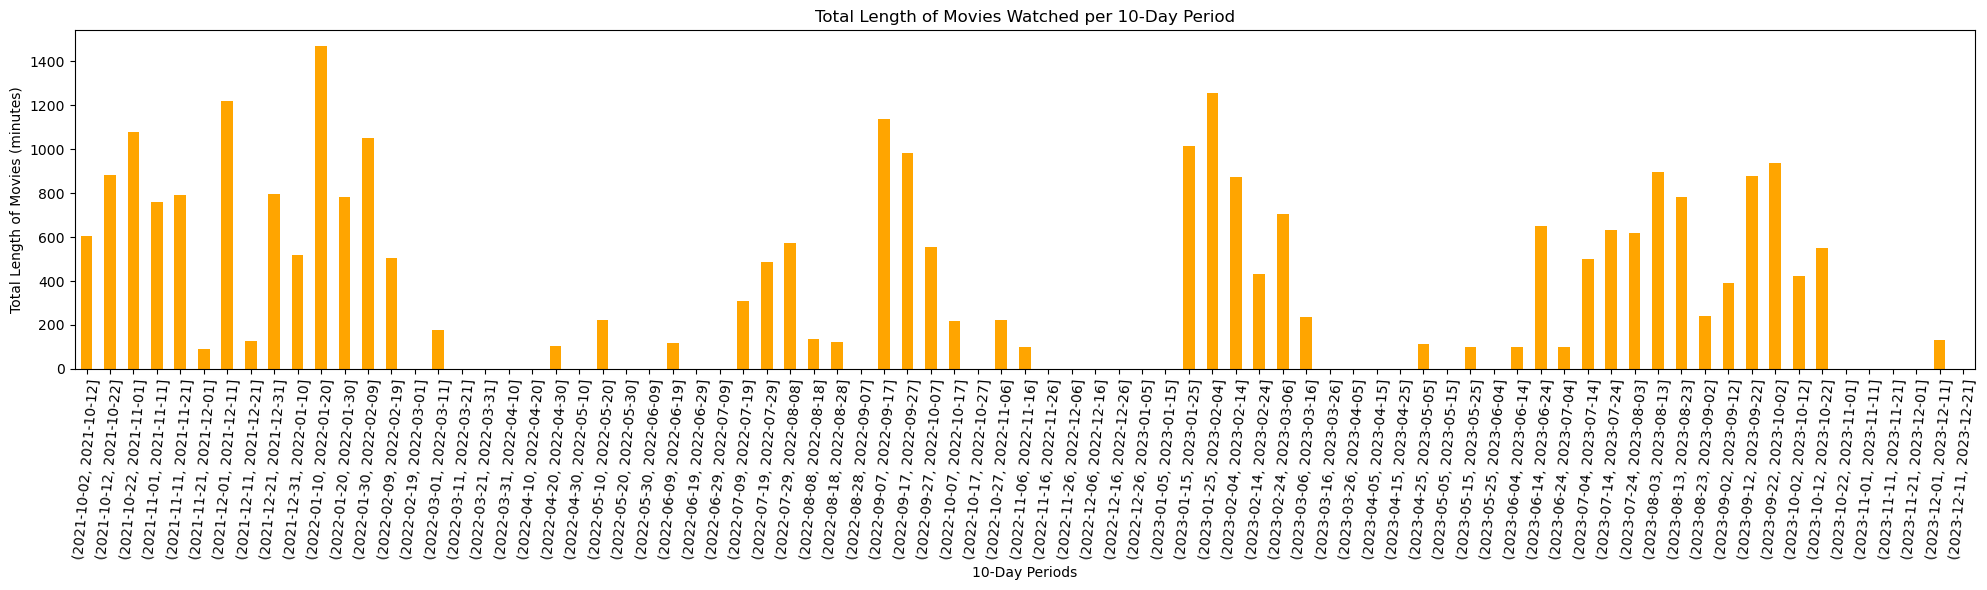

In [28]:
merged_df['Watch Date'] = pd.to_datetime(merged_df['Watch Date'])

start_date = '2021-10-02'
end_date = '2023-12-22'

date_range = pd.date_range(start=start_date, end=end_date, freq='10D')

length_per_period = merged_df.groupby(pd.cut(merged_df['Watch Date'], bins=date_range))['Length_Minutes'].sum()

plt.figure(figsize=(20, 6))
length_per_period.plot(kind='bar', color='orange')
plt.title('Total Length of Movies Watched per 10-Day Period')
plt.xlabel('10-Day Periods')
plt.ylabel('Total Length of Movies (minutes)')
plt.xticks(rotation=85)
plt.tight_layout()
plt.show()

Movies per Day for Specific Periods

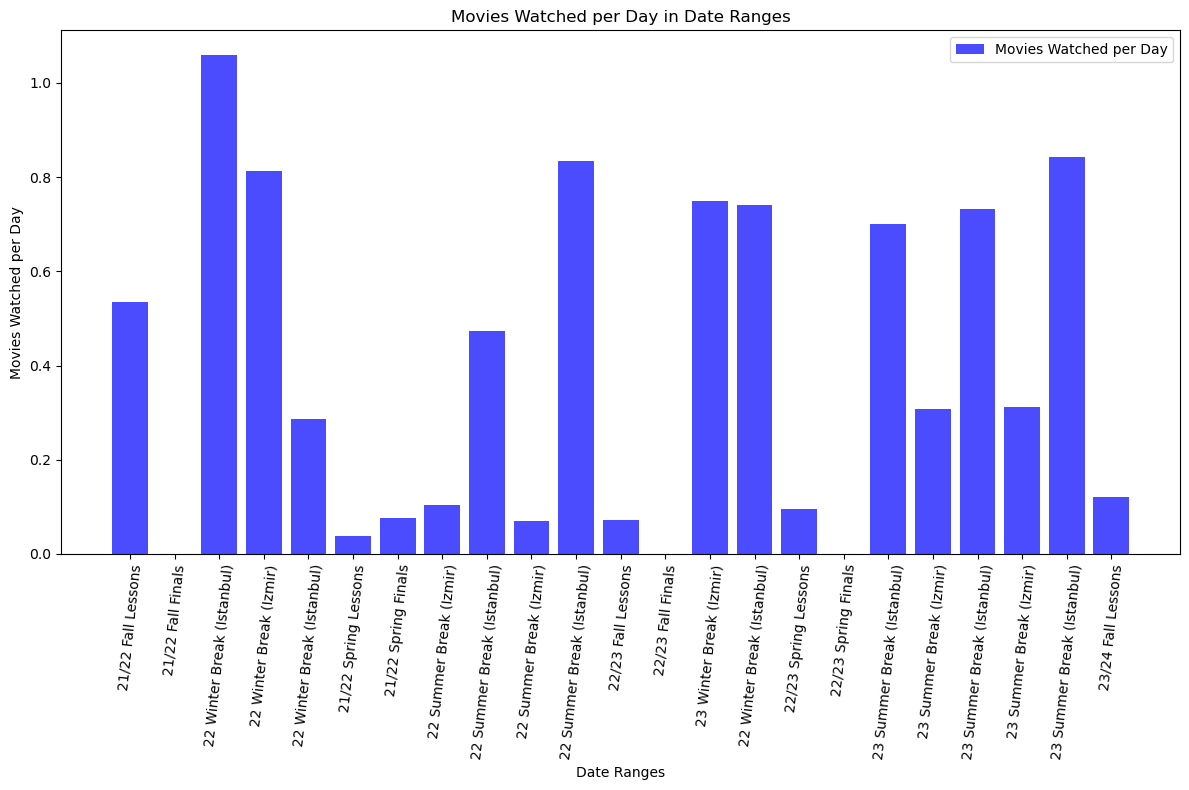

In [29]:
custom_names = [
    "21/22 Fall Lessons",
    "21/22 Fall Finals",
    "22 Winter Break (Istanbul)",
    "22 Winter Break (Izmir)",
    "22 Winter Break (Istanbul)",
    "21/22 Spring Lessons",
    "21/22 Spring Finals",
    "22 Summer Break (Izmir)",
    "22 Summer Break (Istanbul)",
    "22 Summer Break (Izmir)",
    "22 Summer Break (Istanbul)",
    "22/23 Fall Lessons",
    "22/23 Fall Finals",
    "23 Winter Break (Izmir)",
    "22 Winter Break (Istanbul)",
    "22/23 Spring Lessons",
    "22/23 Spring Finals",
    "23 Summer Break (Istanbul)",
    "23 Summer Break (Izmir)",
    "23 Summer Break (Istanbul)",
    "23 Summer Break (Izmir)",
    "23 Summer Break (Istanbul)",
    "23/24 Fall Lessons",
]

plt.figure(figsize=(12, 8))
plt.bar(range(len(results_df)), results_df['Movies Watched per Day'], color='blue', alpha=0.7, label='Movies Watched per Day')
plt.title('Movies Watched per Day in Date Ranges')
plt.xlabel('Date Ranges')
plt.ylabel('Movies Watched per Day')
plt.xticks(range(len(results_df)), custom_names, rotation=84)
plt.legend()
plt.tight_layout()
plt.show()

Minutes Watched per Day for Specific Periods

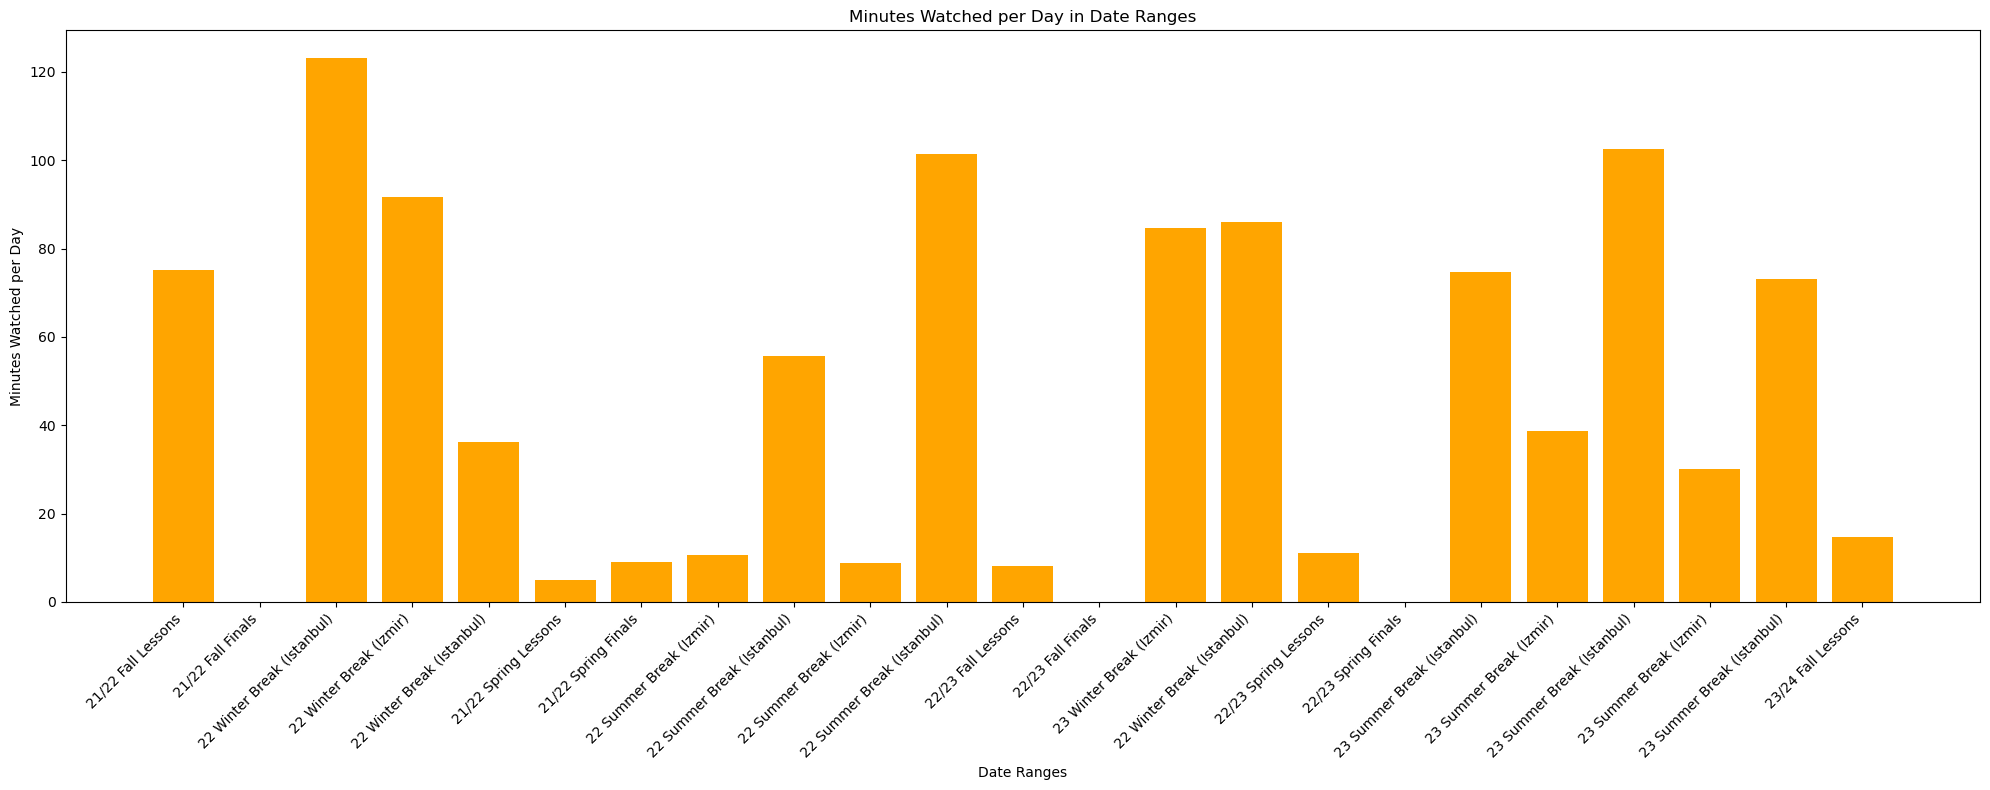

In [30]:
minutes_per_day_per_range = []

for start_date, end_date in date_ranges:
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    filtered_data = merged_df.loc[(merged_df['Watch Date'] >= start) & (merged_df['Watch Date'] <= end)]
    
    total_minutes = filtered_data['Length_Minutes'].sum()
    days_count = (end - start).days + 1
    
    if days_count > 0:
        minutes_per_day = total_minutes / days_count
    else:
        minutes_per_day = 0
    
    minutes_per_day_per_range.append(minutes_per_day)

plt.figure(figsize=(20, 8))
plt.bar(range(len(date_ranges)), minutes_per_day_per_range, color='orange')
plt.title('Minutes Watched per Day in Date Ranges')
plt.xlabel('Date Ranges')
plt.ylabel('Minutes Watched per Day')
plt.xticks(range(len(date_ranges)), custom_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Avg. Movie Length for Specific Periods

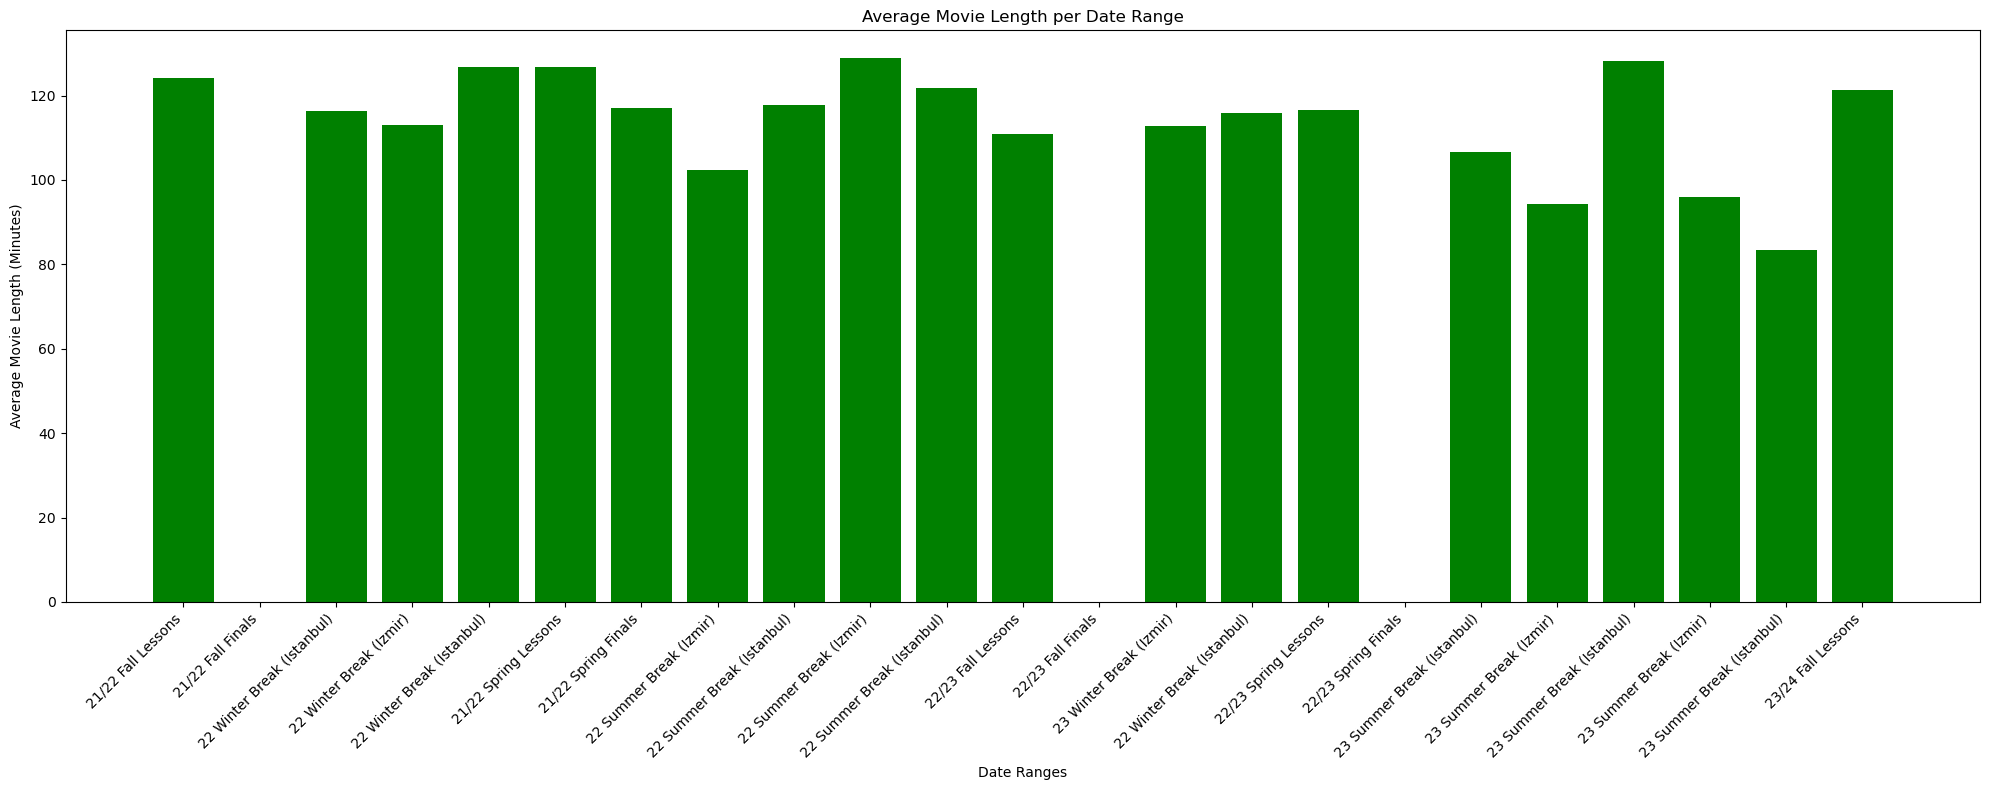

In [31]:
avg_length_per_range = []

for i in range(len(date_ranges)):
    start_date, end_date = date_ranges[i]
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    filtered_data = merged_df.loc[(merged_df['Watch Date'] >= start) & (merged_df['Watch Date'] <= end)]
    
    total_minutes = filtered_data['Length_Minutes'].sum()
    total_movies = filtered_data.shape[0]

    if total_movies > 0:
        avg_length = total_minutes / total_movies
    else:
        avg_length = 0
    
    avg_length_per_range.append(avg_length)

plt.figure(figsize=(20, 8))
plt.bar(range(len(date_ranges)), avg_length_per_range, color='green')
plt.title('Average Movie Length per Date Range')
plt.xlabel('Date Ranges')
plt.ylabel('Average Movie Length (Minutes)')
plt.xticks(range(len(date_ranges)), custom_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

Minutes Watched per Day in Istanbul vs Izmir

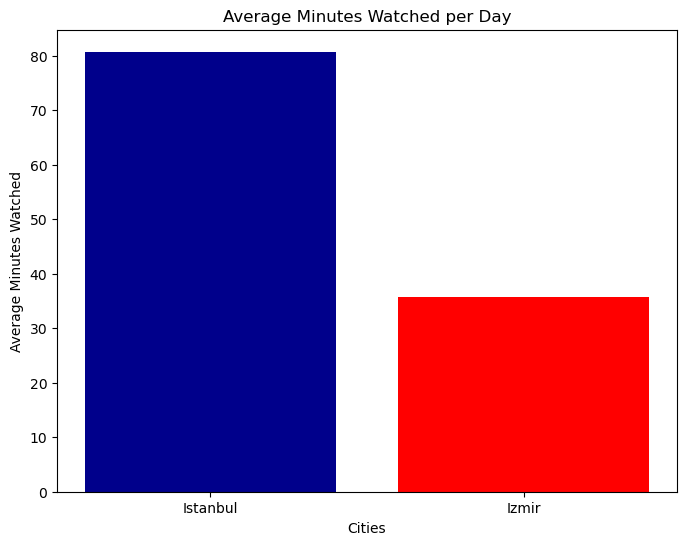

In [32]:
total_days_istanbul = 0
total_days_izmir = 0

for (start_date, end_date), name in zip(date_ranges, custom_names):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    total_days = (end - start).days + 1 

    if name.endswith("(Istanbul)"):
        total_days_istanbul += total_days
    elif name.endswith("(Izmir)"):
        total_days_izmir += total_days

total_minutes_per_range = []
total_minutes_istanbul = 0
total_minutes_izmir = 0

for start_date, end_date in date_ranges:
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    filtered_data = merged_df.loc[(merged_df['Watch Date'] >= start) & (merged_df['Watch Date'] <= end)]
    
    total_minutes = filtered_data['Length_Minutes'].sum()
    total_minutes_per_range.append(total_minutes)
    
    custom_name = custom_names[date_ranges.index((start_date, end_date))]
    if custom_name.endswith('(Istanbul)'):
        total_minutes_istanbul += total_minutes
    elif custom_name.endswith('(Izmir)'):
        total_minutes_izmir += total_minutes

avg_minutes_istanbul = total_minutes_istanbul / total_days_istanbul
avg_minutes_izmir = total_minutes_izmir / total_days_izmir

categories = ['Istanbul', 'Izmir']
avg_minutes = [avg_minutes_istanbul, avg_minutes_izmir]

plt.figure(figsize=(8, 6))
plt.bar(categories, avg_minutes, color=['darkblue', 'red'])
plt.title('Average Minutes Watched per Day')
plt.xlabel('Cities')
plt.ylabel('Average Minutes Watched')
plt.show()

Correlation Matrix for Avg. Length of Movies and Minutes Watched per Day

Correlation Matrix:
                          Average_Movie_Length  Minutes_Watched_Per_Day  \
Average_Movie_Length                  1.000000                 0.426047   
Minutes_Watched_Per_Day               0.426047                 1.000000   
Number_of_Movies_Per_Day              0.388620                 0.982859   

                          Number_of_Movies_Per_Day  
Average_Movie_Length                      0.388620  
Minutes_Watched_Per_Day                   0.982859  
Number_of_Movies_Per_Day                  1.000000  


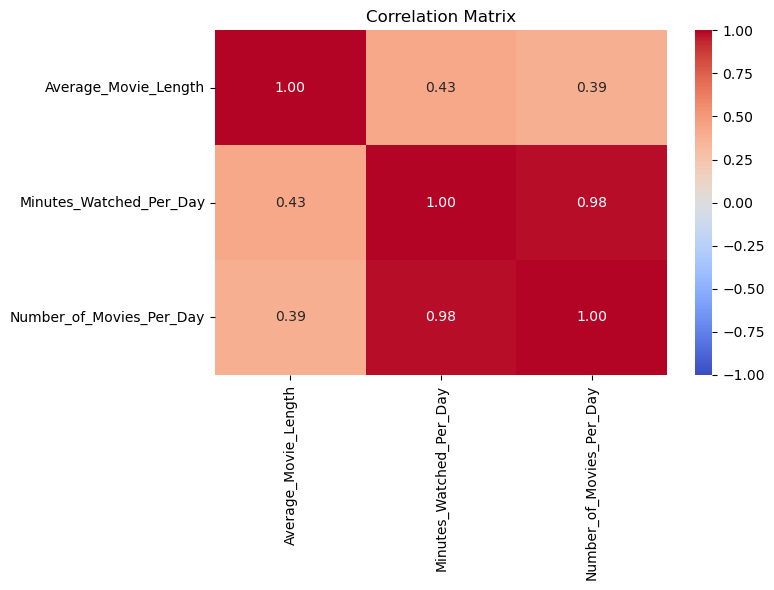

In [33]:
movies_per_day = results_df['Movies Watched per Day']

data = {
    'Average_Movie_Length': avg_length_per_range,
    'Minutes_Watched_Per_Day': minutes_per_day_per_range,
    'Number_of_Movies_Per_Day': movies_per_day
}

df = pd.DataFrame(data, columns=['Average_Movie_Length', 'Minutes_Watched_Per_Day', 'Number_of_Movies_Per_Day'])

correlation_matrix = df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Hypothesis 1

Null Hypothesis: Location (Istanbul, Izmir) has no effect on minutes watched per day

significance level = 0.05

As p-value = 1.4218138770203567e-07 is less than significance level my null hypothesis is rejected thus implying that location has an effect on minutes watched per day.

In [44]:

istanbul_days, izmir_days = [], []
istanbul_minutes, izmir_minutes = [], []

for (start_date, end_date), name in zip(date_ranges, custom_names):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    total_days = (end - start).days + 1

    if name.endswith("(Istanbul)"):
        istanbul_days.extend(pd.date_range(start=start, end=end))
        istanbul_filtered_data = merged_df.loc[(merged_df['Watch Date'] >= start) & (merged_df['Watch Date'] <= end)]
        istanbul_daily_minutes = istanbul_filtered_data.groupby('Watch Date')['Length_Minutes'].sum().reindex(pd.date_range(start=start, end=end), fill_value=0).tolist()
        istanbul_minutes.extend(istanbul_daily_minutes)
    elif name.endswith("(Izmir)"):
        izmir_days.extend(pd.date_range(start=start, end=end))
        izmir_filtered_data = merged_df.loc[(merged_df['Watch Date'] >= start) & (merged_df['Watch Date'] <= end)]
        izmir_daily_minutes = izmir_filtered_data.groupby('Watch Date')['Length_Minutes'].sum().reindex(pd.date_range(start=start, end=end), fill_value=0).tolist()
        izmir_minutes.extend(izmir_daily_minutes)

overall_minutes = istanbul_minutes + izmir_minutes

from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(istanbul_minutes, izmir_minutes)

significance = 0.05

print("P-value is ", p_value)

if p_value < significance:
    print("Reject Null Hypothesis: Location has a significant effect on minutes watched.")
else:
    print("Accept Null Hypothesis: Location has no significant effect on minutes watched.")

P-value is  1.4256473032275776e-07
Reject Null Hypothesis: Location has a significant effect on minutes watched.


Hypothesis 2

Null Hypothesis: Minutes watched per day has no effect on average length of movies (excluding periods with 0 movies watched)

significance level = 0.05

As p-value = 0.06781946169577907 is more than significance level my null hypothesis is not rejected thus implying that minutes watched per day has no effect on avg length of movies when we do not consider the days/periods without a movie watched.

In [35]:
merged_df['Watch Date'] = pd.to_datetime(merged_df['Watch Date'])

resampled_data = merged_df.resample('7D', on='Watch Date')['Length_Minutes'].sum()
num_movies_per_week = merged_df.resample('7D', on='Watch Date').size()

avg_length_per_week = resampled_data / num_movies_per_week

# turn NaN values into 0 as they are the days and periods without a movie watched
avg_length_per_week = avg_length_per_week.fillna(0)
avg_length_list = avg_length_per_week.tolist()

total_minutes_per_week = merged_df.resample('D', on='Watch Date')['Length_Minutes'].sum().resample('7D').sum()
num_days_per_week = merged_df.resample('D', on='Watch Date').size().resample('7D').count()

minutes_per_day_per_week = total_minutes_per_week / num_days_per_week
minutes_per_day_list = minutes_per_day_per_week.tolist()

In [36]:
from scipy.stats import pearsonr

non_zero_minutes = [m for m in minutes_per_day_list if m != 0.0]
non_zero_lengths = [l for l in avg_length_list if l != 0.0]

corr, p_value = pearsonr(non_zero_minutes, non_zero_lengths)
alpha = 0.05

print(f"P-value: {p_value}")
if p_value < alpha:
    print("There is a significant relationship between non-zero Minutes watched per day and average length of movies.")
else:
    print("There is no significant relationship between non-zero Minutes watched per day and average length of movies.")

P-value: 0.06713728981383793
There is no significant relationship between non-zero Minutes watched per day and average length of movies.


MACHINE LEARNING

Linear Regression

Avg. Length of Movies vs Minutes per Day

R^2 score is 0.52 and too moderate to indicate a possible relation between 2 variables. High Mean Squared Error shows that variance is too big as well.

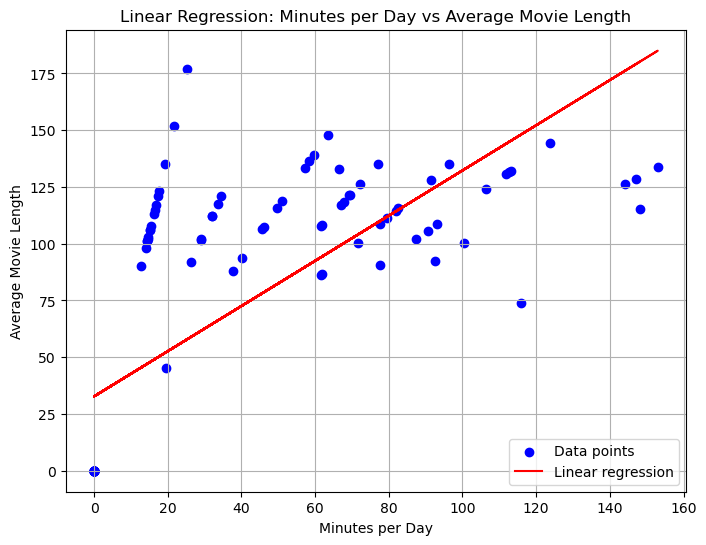

R^2 score: 0.5193973219943033
Mean Squared Error: 1606.3559204180012


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = np.array(minutes_per_day_list).reshape(-1, 1)
y = np.array(avg_length_list)

model = LinearRegression()

model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, y_pred, color='red', label='Linear regression')
plt.title('Linear Regression: Minutes per Day vs Average Movie Length')
plt.xlabel('Minutes per Day')
plt.ylabel('Average Movie Length')
plt.legend()
plt.grid(True)
plt.show()

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print(f"R^2 score: {r2}")
print(f"Mean Squared Error: {mse}")

Random Forest and Hyperparameter Tuning  

R2 score increased to 0.84 and MSE decreased to 462 so overall accuracy has increased with the usage of Grid Search and Cross Validation for hyperparameter tuning and Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


forest = RandomForestRegressor(random_state=42)


grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_


best_forest = RandomForestRegressor(**best_params, random_state=42)
best_forest.fit(X_train, y_train)


y_pred_best_forest = best_forest.predict(X_test)


mse_best = mean_squared_error(y_test, y_pred_best_forest)
r2_best = r2_score(y_test, y_pred_best_forest)

print("Best Hyperparameters:", best_params)
print(f"Mean Squared Error (MSE) with Best Hyperparameters: {mse_best}")
print(f"R-squared (R2) Score with Best Hyperparameters: {r2_best}")

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error (MSE) with Best Hyperparameters: 461.12393113027304
R-squared (R2) Score with Best Hyperparameters: 0.8401330347961244
